# Import

In [1]:
import numpy as np
from google.colab import drive
import pandas as pd
import sys
import scipy.optimize
from scipy.sparse import csr_matrix
import argparse
import pickle
import os
import itertools
from joblib import Parallel, delayed
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from collections import Counter
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
with open('/content/drive/My Drive/Thesis/data/Coat/test.ascii', 'r') as f:
  file = np.loadtxt(f)

In [4]:
with open('/content/drive/My Drive/Thesis/data/R3/ydata-ymusic-rating-study-v1_0-train.txt', 'r') as f:
  data_r3 = np.loadtxt(f)

In [5]:
r3_df = pd.DataFrame(data_r3, columns=["userId", "itemId", "rating"])

In [6]:
num_users, num_items = 15400, 1000

In [7]:
n = len(r3_df)

In [8]:
temp = r3_df.copy()

In [9]:
temp["count"] = 1

In [10]:
temp["propensity"] = temp.groupby(["itemId"])['count'].transform(sum) / num_users

In [11]:
temp = temp[['itemId','propensity']].drop_duplicates().set_index('itemId').to_dict()

In [12]:
raw_matrix = np.ma.array(file, dtype= int, copy= False, mask= file, fill_value= 0, hard_mask= True)

In [13]:
num_user, num_item = raw_matrix.shape

In [14]:
po = n/(num_users*num_items)

In [15]:
po

0.02024051948051948

In [16]:
r3_df.groupby(["rating"])["userId"].count()/n

rating
1.0    0.313900
2.0    0.127210
3.0    0.157621
4.0    0.155532
5.0    0.245736
Name: userId, dtype: float64

In [17]:
r3_df.groupby(["rating"])["userId"].count()

rating
1.0    97844
2.0    39652
3.0    49131
4.0    48480
5.0    76597
Name: userId, dtype: int64

# Metric

In [18]:
class Jitter:
  def __init__(self, cut_off, num_users, num_items):
      self.jitter = 1e-7 * np.random.standard_normal((num_users, num_items)) #create a dataset with standard normal (mean = 0, std = 1)
      discountParams = 2.0 + np.array(range(num_items), dtype = np.longdouble)
      self.discountParams = np.reciprocal(np.log2(discountParams)) # calculate 1/x
      self.cutOff = min(cut_off, num_items)
      self.discountParams[self.cutOff:] = 0.0

      print("Jitter.init: [DBG]\t (NumUsers, NumItems)", num_users, num_items, "\t Sum DiscountFactors",\
                self.discountParams.sum(dtype = np.longdouble), "\t [Requested/Set] Cut-off:", \
                cut_off, self.cutOff)
  def rank(self, predicted_matrix):
    transformedPredictions = -np.ma.add(predicted_matrix, self.jitter)
    sortedPredictions = np.ma.argsort(transformedPredictions, axis = 1)
    return sortedPredictions
dcgJitter = None              

In [19]:
def SET_PROPENSITIES(observed_ratings, inverse_propensities= None, verbose = False):
    numObservations = np.ma.count(observed_ratings)
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems
    inversePropensities = None
    if inverse_propensities is None:
        inversePropensities = np.ones((numUsers, numItems), dtype = np.longdouble) * scale / numObservations
    else:
        inversePropensities = np.array(inverse_propensities, dtype = np.longdouble, copy = True)

    inversePropensities = np.ma.array(inversePropensities, dtype = np.longdouble, copy = False, 
                            mask = np.ma.getmask(observed_ratings), fill_value = 0, hard_mask = True)
 
    if verbose:
        print("Metrics.SET_PROPENSITIES: [LOG]\t NumUsers, NumItems, NumObservations", \
            numUsers, numItems, numObservations)
        print("Metrics.SET_PROPENSITIES: [DBG]\t Sum of observed inverse propensities ", \
            np.ma.sum(inversePropensities, dtype = np.longdouble), \
            "(=? NumUsers * NumItems)", numUsers * numItems)
    return inversePropensities

In [20]:
SET_PROPENSITIES(raw_matrix, verbose= True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 290 300 82360
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  86999.99999999999998 (=? NumUsers * NumItems) 87000


masked_array(
  data=[[1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, --, 1.0563380281690140845, ...,
         1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845],
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        ...,
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, 1.0563380281690140845,
         1.0563380281690140845, ..., 1.0563380281690140845,
         1.0563380281690140845, 1.0563380281690140845],
        [1.0563380281690140845, --, 1.0563380281690140845, ...,
         1.0563380281690140845, 1.0563380281690140845,
         1.0563380

In [21]:
def ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MSE'):
    delta = np.ma.subtract(predicted_ratings, observed_ratings)
    rectifiedDelta = None
    if mode == 'MSE':
        rectifiedDelta = np.square(delta)
    elif mode == 'MAE':
        rectifiedDelta = np.ma.abs(delta)
    else:
        print("Metrics.ITEMWISE_METRICS: [ERR]\t Unrecognized itemwise metric ", mode)
        sys.exit(0)

    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)

    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    observedError = np.ma.multiply(rectifiedDelta, inversePropensities)
    cumulativeError = np.ma.sum(observedError, dtype = np.longdouble)
    vanillaMetric = cumulativeError / scale
    
    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)
    selfNormalizedMetric = cumulativeError / globalNormalizer
    
    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perUserError = np.ma.sum(observedError, axis = 1, dtype = np.longdouble)
    perUserEstimate = np.ma.divide(perUserError, perUserNormalizer)
    userNormalizedMetric = np.ma.sum(perUserEstimate, dtype = np.longdouble) / numUsers

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    perItemError = np.ma.sum(observedError, axis = 0, dtype = np.longdouble)
    perItemEstimate = np.ma.divide(perItemError, perItemNormalizer)
    itemNormalizedMetric = np.ma.sum(perItemEstimate, dtype = np.longdouble) / numItems
   
    if verbose:
        print("Metrics.ITEMWISE_METRICS: [LOG]\t Vanilla, SelfNormalized, UserNormalized, ItemNormalized", \
            vanillaMetric, selfNormalizedMetric, userNormalizedMetric, itemNormalizedMetric)

    return vanillaMetric, selfNormalizedMetric, userNormalizedMetric, itemNormalizedMetric

In [22]:
def MSE(observed_ratings, predicted_ratings, inverse_propensities, verbose = False):
    return ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MSE')


def MAE(observed_ratings, predicted_ratings, inverse_propensities, verbose = False):
    return ITEMWISE_METRICS(observed_ratings, predicted_ratings, inverse_propensities, verbose, mode = 'MAE')

In [23]:
def DCG(observed_ratings, predicted_ratings, inverse_propensities, cut_off = 50, verbose = False):
    global dcgJitter
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    if dcgJitter is None or dcgJitter.cutOff != cut_off:
        dcgJitter = Jitter(cut_off, numUsers, numItems)
 
    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)
    
    predictedRankings = dcgJitter.rank(predicted_ratings)
    weightedGain = np.ma.multiply(observed_ratings, inversePropensities)
 
    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    staticIndices = np.ogrid[0:numUsers, 0:numItems]
    rankedGains = weightedGain[staticIndices[0], predictedRankings]
    perUserDCG = np.ma.dot(rankedGains, dcgJitter.discountParams)

    dcgValue = np.ma.sum(perUserDCG, dtype = np.longdouble) / numUsers
    snDCGValue = dcgValue * scale / np.ma.sum(inversePropensities, dtype = np.longdouble)

    perUserNormalizedEstimates = np.ma.divide(perUserDCG, perUserNormalizer)
    uDCGValue = numItems * np.ma.sum(perUserNormalizedEstimates, dtype = np.longdouble) / numUsers
    
    if verbose:
        print("Metrics.DCG: [LOG]\t DCG, SN-DCG, UN-DCG, IN-DCG", dcgValue, snDCGValue, uDCGValue, 0.0)
    return dcgValue, snDCGValue, uDCGValue, 0.0

In [24]:
def CG(observed_ratings, selected_items, inverse_propensities, verbose = False):
    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, verbose)

    clippedSelections = np.clip(selected_items, 0, 1)
    weightedGain = np.ma.multiply(observed_ratings, inversePropensities)
    cumulativeGain = np.ma.multiply(weightedGain, clippedSelections)
    
    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems

    globalGain = np.ma.sum(cumulativeGain, dtype = np.longdouble)
    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)

    cg = globalGain / numUsers
    snCG = numItems * globalGain / globalNormalizer

    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perUserGain = np.ma.sum(cumulativeGain, axis = 1, dtype = np.longdouble)
    perUserEstimate = np.ma.divide(perUserGain, perUserNormalizer)
    unCG = numItems * np.ma.sum(perUserEstimate, dtype = np.longdouble) / numUsers

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    perItemGain = np.ma.sum(cumulativeGain, axis = 0, dtype = np.longdouble)
    perItemEstimate = np.ma.divide(perItemGain, perItemNormalizer)
    inCG = np.ma.sum(perItemEstimate, dtype = np.longdouble)
       
    if verbose:
        print("Metrics.CG: [LOG]\t CG, SN-CG, UN-CG, IN-CG", cg, snCG, unCG, inCG)
    return cg, snCG, unCG, inCG


In [25]:
x = 1e-7 * np.random.standard_normal((5, 4))

In [26]:
y = np.array(range(20)).reshape(5,4)

In [27]:
shape = (5,3)
a = np.random.randint(0,5, size=shape)
b = np.random.randint(0,5, size=shape)

In [28]:
a

array([[2, 3, 3],
       [3, 1, 0],
       [3, 3, 2],
       [4, 1, 2],
       [0, 3, 4]])

In [29]:
b

array([[4, 2, 0],
       [1, 3, 1],
       [0, 4, 3],
       [0, 1, 0],
       [2, 2, 2]])

In [30]:
inversePropensities = np.random.random(shape)

In [31]:
inversePropensities

array([[0.68268509, 0.60340346, 0.98554577],
       [0.00675616, 0.00654541, 0.62218479],
       [0.39055642, 0.07475298, 0.12460294],
       [0.90466403, 0.4269031 , 0.57831279],
       [0.33550283, 0.47317894, 0.35132238]])

In [32]:
obs = np.random.random(shape)
obs

array([[0.02192497, 0.57824025, 0.71081227],
       [0.5079452 , 0.01267618, 0.29790505],
       [0.90212526, 0.71431484, 0.17000135],
       [0.65050905, 0.37871847, 0.76298707],
       [0.0506962 , 0.84838684, 0.07018855]])

In [33]:
obs = obs < inversePropensities
obs

array([[ True,  True,  True],
       [False, False,  True],
       [False, False, False],
       [ True,  True, False],
       [ True, False,  True]])

In [34]:
inversePropensities = np.reciprocal(inversePropensities)
inversePropensities

array([[  1.46480422,   1.65726593,   1.01466621],
       [148.01311645, 152.77877384,   1.60723955],
       [  2.56044951,  13.37739283,   8.02549268],
       [  1.10538273,   2.34245195,   1.72916804],
       [  2.98060075,   2.11336538,   2.84638858]])

In [35]:
observed_a = np.ma.array(a, dtype = np.longdouble, copy = True, 
                        mask = np.logical_not(obs), fill_value = 0, hard_mask = True)

In [36]:
observed_a

masked_array(
  data=[[2.0, 3.0, 3.0],
        [--, --, 0.0],
        [--, --, --],
        [4.0, 1.0, --],
        [0.0, --, 4.0]],
  mask=[[False, False, False],
        [ True,  True, False],
        [ True,  True,  True],
        [False, False,  True],
        [False,  True, False]],
  fill_value=0.0,
  dtype=float128)

In [37]:
MSE(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 8
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  15.01879991760127897 (=? NumUsers * NumItems) 15
Metrics.ITEMWISE_METRICS: [LOG]	 Vanilla, SelfNormalized, UserNormalized, ItemNormalized 3.9499866203768751276 3.9450421891708763488 2.830835294547432776 3.6166787421628750912


(3.9499866203768751276,
 3.9450421891708763488,
 2.830835294547432776,
 3.6166787421628750912)

In [38]:
MAE(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 8
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  15.01879991760127897 (=? NumUsers * NumItems) 15
Metrics.ITEMWISE_METRICS: [LOG]	 Vanilla, SelfNormalized, UserNormalized, ItemNormalized 1.6875748095709399118 1.6854623726558741395 1.225413652847067553 1.5680866680805637024


(1.6875748095709399118,
 1.6854623726558741395,
 1.225413652847067553,
 1.5680866680805637024)

In [39]:
DCG(observed_a, b, inversePropensities, cut_off = 50, verbose = True)

Jitter.init: [DBG]	 (NumUsers, NumItems) 5 3 	 Sum DiscountFactors 2.1309297535714574372 	 [Requested/Set] Cut-off: 50 3
Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 8
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  15.01879991760127897 (=? NumUsers * NumItems) 15
Metrics.DCG: [LOG]	 DCG, SN-DCG, UN-DCG, IN-DCG 4.7054469258736597295 4.699556840449461275 3.0653666773592650552 0.0


(4.7054469258736597295, 4.699556840449461275, 3.0653666773592650552, 0.0)

In [40]:
CG(observed_a, b, inversePropensities, verbose = True)

Metrics.SET_PROPENSITIES: [LOG]	 NumUsers, NumItems, NumObservations 5 3 8
Metrics.SET_PROPENSITIES: [DBG]	 Sum of observed inverse propensities  15.01879991760127897 (=? NumUsers * NumItems) 15
Metrics.CG: [LOG]	 CG, SN-CG, UN-CG, IN-CG 4.3258824966303767836 4.3204675343873445836 2.7260341495394187824 4.4385772961738795724


(4.3258824966303767836,
 4.3204675343873445836,
 2.7260341495394187824,
 4.4385772961738795724)

# Matrix Fatorization

In [41]:
def PREDICTED_SCORES(user_vectors, item_vectors, user_biases, item_biases, global_bias, use_bias = True):
    rawScores = np.dot(user_vectors, item_vectors.T)
    if use_bias:
        biasedScores = rawScores + user_biases[:,None] + item_biases[None,:] + global_bias
        return biasedScores
    else:
        return rawScores

In [42]:
def GENERATE_MATRIX(observed_ratings, inverse_propensities, l2_regularization, num_dimensions, normalization,
        bias_mode = 'Regularized', mode = 'MSE', start_vec = None, verbose = False):

    metricMode = None
    if mode == 'MSE':
        metricMode = 1
    elif mode == 'MAE':
        metricMode = 2
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Metric not supported:", mode)
        sys.exit(0)

    inversePropensities = SET_PROPENSITIES(observed_ratings, inverse_propensities, False)

    numUsers, numItems = np.shape(observed_ratings)
    scale = numUsers * numItems
    numObservations = np.ma.count(observed_ratings)

    perUserNormalizer = np.ma.sum(inversePropensities, axis = 1, dtype = np.longdouble)
    perUserNormalizer = np.ma.masked_less_equal(perUserNormalizer, 0.0, copy = False)

    perItemNormalizer = np.ma.sum(inversePropensities, axis = 0, dtype = np.longdouble)
    perItemNormalizer = np.ma.masked_less_equal(perItemNormalizer, 0.0, copy = False)

    globalNormalizer = np.ma.sum(inversePropensities, dtype = np.longdouble)

    normalizedPropensities = None
    if normalization == 'Vanilla':
        normalizedPropensities = inversePropensities
    elif normalization == 'SelfNormalized':
        normalizedPropensities = scale * np.ma.divide(inversePropensities, globalNormalizer)
    elif normalization == 'UserNormalized':
        normalizedPropensities = numItems * np.ma.divide(inversePropensities, perUserNormalizer[:, None])
    elif normalization == 'ItemNormalized':
        normalizedPropensities = numUsers * np.ma.divide(inversePropensities, perItemNormalizer[None, :])
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Normalization not supported:", normalization)
        sys.exit(0)
    
    useBias = None
    regularizeBias = None
    if bias_mode == 'None':
        useBias = False
        regularizeBias = False
    elif bias_mode == 'Regularized':
        useBias = True
        regularizeBias = True
    elif bias_mode == 'Free':
        useBias = True
        regularizeBias = False
    else:
        print("MF.GENERATE_MATRIX: [ERR]\t Bias mode not supported:", bias_mode)
        sys.exit(0)

    if verbose:
        print("MF.GENERATE_MATRIX: [LOG]\t Lamda:", l2_regularization, "\t NumDims:", num_dimensions,\
            "\t Normalization:", normalization, "\t Metric:", mode, "\t BiasMode:", bias_mode)

    normalizedPropensities = np.ma.filled(normalizedPropensities, 0.0)
    observedRatings = np.ma.filled(observed_ratings, 0)
    
    def Mat2Vec(user_vectors, item_vectors, user_biases, item_biases, global_bias):
        allUserParams = np.concatenate((user_vectors, user_biases[:,None]), axis = 1)
        allItemParams = np.concatenate((item_vectors, item_biases[:,None]), axis = 1)
        
        allParams = np.concatenate((allUserParams, allItemParams), axis = 0)
        paramVector = np.reshape(allParams, (numUsers + numItems)*(num_dimensions + 1))
        paramVector = np.concatenate((paramVector, [global_bias]))
        return paramVector.astype(float)
        
    def Vec2Mat(paramVector):
        globalBias = paramVector[-1]
        remainingParams = paramVector[:-1]
        allParams = np.reshape(remainingParams, (numUsers + numItems, num_dimensions + 1))
        allUserParams = allParams[0:numUsers,:]
        allItemParams = allParams[numUsers:, :]
        
        userVectors = (allUserParams[:,0:-1]).astype(np.longdouble)
        userBiases = (allUserParams[:,-1]).astype(np.longdouble)
        
        itemVectors = (allItemParams[:,0:-1]).astype(np.longdouble)
        itemBiases = (allItemParams[:,-1]).astype(np.longdouble)
        return userVectors, itemVectors, userBiases, itemBiases, globalBias
    
    def Objective(paramVector):
        userVectors, itemVectors, userBiases, itemBiases, globalBias = Vec2Mat(paramVector)
        biasedScores = PREDICTED_SCORES(userVectors, itemVectors, userBiases, itemBiases, globalBias, useBias)

        delta = np.subtract(biasedScores, observedRatings)
        loss = None
        if metricMode == 1:
            loss = np.square(delta)
        elif metricMode == 2:
            loss = np.abs(delta)
        else:
            sys.exit(0)

        weightedLoss = np.multiply(loss, normalizedPropensities)
        objective = np.sum(weightedLoss, dtype = np.longdouble)

        gradientMultiplier = None
        if metricMode == 1:
            gradientMultiplier = np.multiply(normalizedPropensities, 2 * delta)
        elif metricMode == 2:
            gradientMultiplier = np.zeros(np.shape(delta), dtype = np.int)
            gradientMultiplier[delta > 0] = 1
            gradientMultiplier[delta < 0] = -1
            gradientMultiplier = np.multiply(normalizedPropensities, gradientMultiplier)
        else:
            sys.exit(0)

        userVGradient = np.dot(gradientMultiplier, itemVectors)
        itemVGradient = np.dot(gradientMultiplier.T, userVectors)

        userBGradient = None
        itemBGradient = None
        globalBGradient = None
        if useBias:
            userBGradient = np.sum(gradientMultiplier, axis = 1, dtype = np.longdouble)
            itemBGradient = np.sum(gradientMultiplier, axis = 0, dtype = np.longdouble)
            globalBGradient = np.sum(gradientMultiplier, dtype = np.longdouble)
        else:
            userBGradient = np.zeros(np.shape(userBiases), dtype = np.longdouble)
            itemBGradient = np.zeros(np.shape(itemBiases), dtype = np.longdouble)
            globalBGradient = 0.0

        if l2_regularization > 0:
            scaledPenalty = 1.0 * l2_regularization * scale / (numUsers + numItems)
            if regularizeBias:
                scaledPenalty /= (num_dimensions + 1)
            else:
                scaledPenalty /= num_dimensions

            userVGradient += 2 * scaledPenalty * userVectors
            itemVGradient += 2 * scaledPenalty * itemVectors
          
            objective += scaledPenalty * np.sum(np.square(userVectors), dtype = np.longdouble)
            objective += scaledPenalty * np.sum(np.square(itemVectors), dtype = np.longdouble)
 
            if regularizeBias:
                userBGradient += 2 * scaledPenalty * userBiases
                itemBGradient += 2 * scaledPenalty * itemBiases
                globalBGradient += 2 * scaledPenalty * globalBias
                objective += scaledPenalty * np.sum(np.square(userBiases), dtype = np.longdouble)
                objective += scaledPenalty * np.sum(np.square(itemBiases), dtype = np.longdouble)
                objective += scaledPenalty * globalBias * globalBias
            
        gradient = Mat2Vec(userVGradient, itemVGradient, userBGradient, itemBGradient, globalBGradient)

        if verbose:
            print(".")
            sys.stdout.flush()
        
        return objective, gradient
    
    def ObjectiveOnly(paramVector):
        objective, gradient = Objective(paramVector)
        return objective
    def GradientOnly(paramVector):
        objective, gradient = Objective(paramVector)
        return gradient
    
    userVectorsInit = None
    itemVectorsInit = None
    userBiasesInit = None
    itemBiasesInit = None
    globalBiasInit = None
    if start_vec is None:
        userVectorsInit = np.random.standard_normal((numUsers, num_dimensions))
        itemVectorsInit = np.random.standard_normal((numItems, num_dimensions))
        userBiasesInit = np.zeros(numUsers, dtype = float)
        itemBiasesInit = np.zeros(numItems, dtype = float)
        globalBiasInit = 0
    else:
        userVectorsInit = start_vec[0]
        itemVectorsInit = start_vec[1]
        userBiasesInit = start_vec[2]
        itemBiasesInit = start_vec[3]
        globalBiasInit = start_vec[4]
    
    startVector = Mat2Vec(userVectorsInit, itemVectorsInit, userBiasesInit, itemBiasesInit, globalBiasInit)

    if verbose:
        print("MF.GENERATE_MATRIX: [DBG]\t Checking gradients")
        print(scipy.optimize.check_grad(ObjectiveOnly, GradientOnly, startVector))

    ops = {'maxiter': 2000, 'disp': False, 'gtol': 1e-5,\
            'ftol': 1e-5, 'maxcor': 50}

    result = scipy.optimize.minimize(fun = Objective, x0 = startVector,
                    method = 'L-BFGS-B', jac = True, tol = 1e-5, options = ops)
    
    if verbose:
        print("MF.GENERATE_MATRIX: [DBG]\t Optimization result:", result['message'])
        sys.stdout.flush()

    return Vec2Mat(result['x'])
 

In [43]:
rows = [2,1,4,3,0,4,3]
cols = [0,2,1,1,0,0,0]
vals = [1,2,3,4,5,4,5]

In [44]:
checkY = scipy.sparse.coo_matrix((vals, (rows,cols)), dtype = int)

In [45]:
checkY = checkY.toarray()

In [46]:
checkY = np.ma.array(checkY, dtype = int, mask = checkY <= 0, hard_mask = True, copy = False)

In [47]:
checkY

masked_array(
  data=[[5, --, --],
        [--, --, 2],
        [1, --, --],
        [5, 4, --],
        [4, 3, --]],
  mask=[[False,  True,  True],
        [ True,  True, False],
        [False,  True,  True],
        [False, False,  True],
        [False, False,  True]],
  fill_value=999999)

In [48]:
randomPropensities = np.random.random(size = np.shape(checkY))
randomInvPropensities = np.reciprocal(randomPropensities)

In [49]:
randomPropensities

array([[0.01122689, 0.48025187, 0.11986694],
       [0.99850098, 0.69313106, 0.55415292],
       [0.43642062, 0.83753065, 0.12270462],
       [0.89209186, 0.31989718, 0.86191889],
       [0.23631792, 0.14301066, 0.76996319]])

In [50]:
randomInvPropensities

array([[89.07183779,  2.08224073,  8.34258352],
       [ 1.00150127,  1.4427286 ,  1.80455603],
       [ 2.29136744,  1.19398616,  8.14965245],
       [ 1.12096079,  3.12600443,  1.16020197],
       [ 4.23158773,  6.99248566,  1.29876339]])

In [51]:
userVectors, itemVectors, userBiases, itemBiases, globalBias = GENERATE_MATRIX(checkY, None, 1.0, 5, 'Vanilla',
                                                'Regularized', 'MSE', None, verbose = True)

MF.GENERATE_MATRIX: [LOG]	 Lamda: 1.0 	 NumDims: 5 	 Normalization: Vanilla 	 Metric: MSE 	 BiasMode: Regularized
MF.GENERATE_MATRIX: [DBG]	 Checking gradients
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
5.408484899420198e-07
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
MF.GENERATE_MATRIX: [DBG]	 Optimization result: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [52]:
userVectors, itemVectors, userBiases, itemBiases, globalBias

(array([[ 1.61613245e-01, -6.08841814e-01,  7.52760048e-01,
         -2.04434348e-01, -2.64624416e-01],
        [ 1.91199140e-04,  7.65018887e-05,  4.79501352e-04,
         -1.32561965e-04,  2.53838751e-04],
        [-1.13115783e-01,  4.21512452e-01, -5.17904340e-01,
          1.38065587e-01,  1.82337926e-01],
        [ 1.28644222e-01, -4.92916029e-01,  6.03576109e-01,
         -1.59007624e-01, -2.09146464e-01],
        [ 1.03132311e-01, -3.78422080e-01,  4.67139774e-01,
         -1.26449351e-01, -1.64937728e-01]], dtype=float128),
 array([[ 2.42236250e-01, -9.06566332e-01,  1.11434637e+00,
         -2.98702760e-01, -3.91101982e-01],
        [ 8.74389510e-02, -3.40003602e-01,  4.14416726e-01,
         -1.08345147e-01, -1.42876845e-01],
        [ 1.88903886e-04,  2.23757105e-04,  1.99073120e-04,
         -2.36440491e-04,  2.04460517e-04]], dtype=float128),
 array([ 0.67463379,  0.13672695, -0.46519977,  1.05374605,  0.30652761],
       dtype=float128),
 array([0.92581739, 0.6438903 , 0.

In [53]:
userVectors.shape

(5, 5)

In [54]:
itemVectors.shape

(3, 5)

In [55]:
np.dot(userVectors, itemVectors.T)

array([[ 1.59449974e+00,  5.93054227e-01,  3.83822923e-05],
       [ 4.51611705e-04,  1.67515481e-04,  2.31934950e-07],
       [-1.09920786e+00, -4.08845302e-01, -2.55158262e-05],
       [ 1.27990983e+00,  4.76083667e-01,  2.89973552e-05],
       [ 9.90880857e-01,  3.68539143e-01,  2.39769308e-05]],
      dtype=float128)

In [56]:
completeScores = PREDICTED_SCORES(userVectors, itemVectors, userBiases, itemBiases, globalBias, True)

In [57]:
completeScores

array([[4.90138556, 3.61801295, 2.51783375],
       [2.76943058, 2.48721939, 1.97988875],
       [1.06784438, 1.47627985, 1.37793629],
       [4.9659079 , 3.88015465, 2.89693663],
       [3.92966049, 3.02539168, 2.14971316]], dtype=float128)

In [58]:
def MF_TRAIN(params, train_observations, inv_propensities, normalization, metric, start_vector):
    retVal = None
    actualStart = None
    if start_vector is not None:
        actualStart = (start_vector[0][:,0:params[1]], start_vector[1][:,0:params[1]],
                        start_vector[2], start_vector[3], start_vector[4])

    tempInvPropensities = None
    if inv_propensities is not None:
        tempInvPropensities = (4.0 / 3.0) * inv_propensities
        if params[2] >= 0:
            tempInvPropensities = np.clip(tempInvPropensities, a_min = 0, a_max = params[2])

    retVal = GENERATE_MATRIX(train_observations, tempInvPropensities, params[0], 
                                params[1], normalization, bias_mode = params[3], mode = metric, 
                                start_vec = actualStart, verbose = False)

    return retVal

In [59]:
def FINAL_TRAIN(approach_tuple, metric, observations, start_vector):
    invP = approach_tuple[1]
    normN = approach_tuple[2]
    bestLambda = approach_tuple[3][0]
    bestDims = approach_tuple[3][1]
    bestClip = approach_tuple[3][2]
    bestBias = approach_tuple[3][3]
    actualStart = None
    if start_vector is not None:
        actualStart = (start_vector[0][:,0:bestDims], start_vector[1][:,0:bestDims],
                        start_vector[2], start_vector[3], start_vector[4])

    tempInvP = None
    if bestClip < 0 or invP is None:
        tempInvP = invP
    else:
        tempInvP = np.clip(invP, a_min = 0, a_max = bestClip)

    retVal = GENERATE_MATRIX(observations, tempInvP, bestLambda, bestDims, normN, bias_mode = bestBias,
                        mode = metric, start_vec = actualStart)

    return retVal

In [60]:
def INIT_PARAMS(partial_observations, num_dimensions):
    averageObservedRating = np.ma.mean(partial_observations, dtype = np.longdouble)
    completeRatings = np.ma.filled(partial_observations.astype(float), averageObservedRating)
    numUsers, numItems = np.shape(partial_observations)

    u,s,vt = scipy.sparse.linalg.svds(completeRatings, k = num_dimensions, ncv = 50, tol = 1e-7, which = 'LM', 
                        v0 = None, maxiter = 2000, return_singular_vectors = True)
            
    startTuple = (u, np.transpose(np.multiply(vt, s[:,None])), 
                     np.zeros(numUsers, dtype = np.longdouble), 
                     np.zeros(numItems, dtype = np.longdouble), 
                     averageObservedRating)
    return startTuple 

In [61]:
def TRAIN_HELPER(approach, gold_inv_propensities, nb_inv_propensities):
    invP = None
    if approach == 'Naive':
        invP = None
    elif approach.startswith('Gold'):
        invP = gold_inv_propensities
    elif approach.startswith('NB'):
        invP = nb_inv_propensities
    else:
        print("TRAIN_HELPER: [ERR] Unrecognized approach", approach)
        sys.exit(0)

    normN = None
    if approach == 'Naive' or approach.endswith('-IPS'):
        normN = 'Vanilla'
    elif approach.endswith('-SNIPS'):
        normN = 'SelfNormalized'
    elif approach.endswith('-UNIPS'):
        normN = 'UserNormalized'
    elif approach.endswith('-INIPS'):
        normN = 'ItemNormalized'
    else:
        print("TRAIN_HELPER: [ERR] Unrecognized approach", approach)
        sys.exit(0)
        
    return invP, normN   

In [62]:
def learn(data, logger, lambdas=None, seed=None, numDims=None, approach=None, metric=None, raw_metric=None,
          output_name=None, propensities_desc=None):
    clipVals = [-1]
    biasModes = ['Free', 'Regularized']
    np.random.seed(seed)

    numBiasModes = len(biasModes)
    numLambdas = len(lambdas)
    numDimSettings = len(numDims)
    numClipSettings = len(clipVals)
    numParamSettings = numLambdas * numDimSettings * numClipSettings * numBiasModes

    paramSettings = list(itertools.product(lambdas, numDims, clipVals, biasModes))
    numApproaches = 1

    selfMatrix = data.train

    logger.log("Starting learning...")
    logger.log("\t-metric: " + raw_metric, 2)
    logger.log("\t-lambda values: " + str(lambdas), 2)
    logger.log("\t-dimension values: " + str(numDims), 2)
    logger.log("\t-propensity scoring method: " + propensities_desc)
    if data.propensities is not None:
        invP = np.reciprocal(data.propensities)
        invP = np.ma.array(invP, dtype=np.longdouble, copy=False,
                              mask=np.ma.getmask(selfMatrix), fill_value=0, hard_mask=True)
    else:
        invP = None

    foldScores = np.zeros((numApproaches, 4, numParamSettings), dtype=float)

    observationIndices = np.ma.nonzero(selfMatrix)
    numObservations = np.ma.count(selfMatrix)

    shuffleIndices = np.random.permutation(numObservations)
    fractionObservations = int(numObservations / 4)
    firstFold = shuffleIndices[:fractionObservations]
    secondFold = shuffleIndices[fractionObservations:2 * fractionObservations]
    thirdFold = shuffleIndices[2 * fractionObservations:3 * fractionObservations]
    fourthFold = shuffleIndices[3 * fractionObservations:]

    logger.log("Split %d observations into folds. Fold sizes: %s" %
               (len(shuffleIndices), str([len(firstFold), len(secondFold), len(thirdFold), len(fourthFold)])),
               2)

    for fold in range(4):
        logger.log("Learning on fold %d " % fold)
        trainObservations = np.ma.copy(selfMatrix)
        testObservations = np.ma.copy(selfMatrix)

        if fold == 0:
            trainObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 1:
            trainObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 2:
            trainObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 3:
            trainObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

        # Get starting params by SVD
        startTuple = INIT_PARAMS(trainObservations, 40)
        normN = "Vanilla"
        approachIndex = 0

        modelsPerLambda = Parallel(n_jobs=-1, verbose=0)(delayed(MF_TRAIN)(param,
                                                                                 trainObservations, invP, normN,
                                                                                 raw_metric, startTuple)
                                                         for param in paramSettings)

        for lambdaIndex, eachModel in enumerate(modelsPerLambda):
            selectedBiasMode = paramSettings[lambdaIndex][3]
            selectedBias = True
            if selectedBiasMode == 'None':
                selectedBias = False
            predictedY = PREDICTED_SCORES(eachModel[0], eachModel[1],
                                             eachModel[2], eachModel[3], eachModel[4], use_bias=selectedBias)

            score = None
            if invP is not None:
                score = metric(testObservations, predictedY, 4.0 * invP)
            else:
                score = metric(testObservations, predictedY, invP)
            score = score[0]
            foldScores[approachIndex, fold, lambdaIndex] = score

            logger.log("\tLambda/NumDims: " + str(paramSettings[lambdaIndex]) +
                       ", Test Fold Score: " + str(score), 2)

    eventualApproachParams = []

    normN = "Vanilla"
    approachIndex = 0
    approachScores = foldScores[approachIndex, :, :]
    allFoldScores = approachScores.sum(axis=0, dtype=float)
    bestLambdaIndex = np.argmin(allFoldScores)
    bestLambda = paramSettings[bestLambdaIndex]
    logger.log("Retraining with best hyperparameter values: " + str(bestLambda))
    logger.log("Chosen from average cross-validation performance:", 2)
    for everyLambdaIndex, everyLambda in enumerate(paramSettings):
        logger.log("\t" + str(everyLambda) + ": " +  str(allFoldScores[everyLambdaIndex]), 2)
    eventualApproachParams.append((approach, invP, normN, bestLambda))

    finalModels = Parallel(n_jobs=-1, verbose=0)(delayed(FINAL_TRAIN)(approachTup,
                                                                            raw_metric, selfMatrix, startTuple)
                                                 for approachTup in eventualApproachParams)

    for approachID, approachTuple in enumerate(eventualApproachParams):
        resultTuple = finalModels[approachID]
        finalBiasMode = approachTuple[3][3]
        finalBias = True
        if finalBiasMode == 'None':
            finalBias = False

        predictedY = PREDICTED_SCORES(resultTuple[0], resultTuple[1],
                                         resultTuple[2], resultTuple[3], resultTuple[4], use_bias=finalBias)
        np.savetxt(output_name, predictedY)
        logger.log("Done.")


# Experiment

## Code


In [63]:
def learn(data, logger, lambdas=None, seed=None, numDims=None, approach=None, metric=None, raw_metric=None,
          output_name=None, propensities_desc=None):
    clipVals = [-1]
    #biasModes = ['Free', 'Regularized']
    biasModes = ['Regularized']
    np.random.seed(seed)

    numBiasModes = len(biasModes)
    numLambdas = len(lambdas)
    numDimSettings = len(numDims)
    numClipSettings = len(clipVals)
    numParamSettings = numLambdas * numDimSettings * numClipSettings * numBiasModes

    paramSettings = list(itertools.product(lambdas, numDims, clipVals, biasModes))
    numApproaches = 1

    selfMatrix = data.train

    logger.log("Starting learning...")
    logger.log("\t-metric: " + raw_metric, 2)
    logger.log("\t-lambda values: " + str(lambdas), 2)
    logger.log("\t-dimension values: " + str(numDims), 2)
    logger.log("\t-propensity scoring method: " + propensities_desc)
    if data.propensities is not None:
        invP = np.reciprocal(data.propensities)
        invP = np.ma.array(invP, dtype=np.longdouble, copy=False,
                              mask=np.ma.getmask(selfMatrix), fill_value=0, hard_mask=True)
    else:
        invP = None

    foldScores = np.zeros((numApproaches, 4, numParamSettings), dtype=float)

    observationIndices = np.ma.nonzero(selfMatrix)
    numObservations = np.ma.count(selfMatrix)

    shuffleIndices = np.random.permutation(numObservations)
    fractionObservations = int(numObservations / 4)
    firstFold = shuffleIndices[:fractionObservations]
    secondFold = shuffleIndices[fractionObservations:2 * fractionObservations]
    thirdFold = shuffleIndices[2 * fractionObservations:3 * fractionObservations]
    fourthFold = shuffleIndices[3 * fractionObservations:]

    logger.log("Split %d observations into folds. Fold sizes: %s" %
               (len(shuffleIndices), str([len(firstFold), len(secondFold), len(thirdFold), len(fourthFold)])),
               2)

    for fold in range(4):
        logger.log("Learning on fold %d " % fold)
        trainObservations = np.ma.copy(selfMatrix)
        testObservations = np.ma.copy(selfMatrix)

        if fold == 0:
            trainObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 1:
            trainObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 2:
            trainObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked
        elif fold == 3:
            trainObservations[observationIndices[0][fourthFold], observationIndices[1][fourthFold]] = \
                np.ma.masked

            testObservations[observationIndices[0][firstFold], observationIndices[1][firstFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][secondFold], observationIndices[1][secondFold]] = \
                np.ma.masked
            testObservations[observationIndices[0][thirdFold], observationIndices[1][thirdFold]] = \
                np.ma.masked

        # Get starting params by SVD
        startTuple = INIT_PARAMS(trainObservations, 40)
        normN = "Vanilla"
        approachIndex = 0

        modelsPerLambda = Parallel(n_jobs=-1, verbose=0)(delayed(MF_TRAIN)(param,
                                                                                 trainObservations, invP, normN,
                                                                                 raw_metric, startTuple)
                                                         for param in paramSettings)

        for lambdaIndex, eachModel in enumerate(modelsPerLambda):
            selectedBiasMode = paramSettings[lambdaIndex][3]
            selectedBias = True
            if selectedBiasMode == 'None':
                selectedBias = False
            predictedY = PREDICTED_SCORES(eachModel[0], eachModel[1],
                                             eachModel[2], eachModel[3], eachModel[4], use_bias=selectedBias)

            score = None
            if invP is not None:
                score = metric(testObservations, predictedY, 4.0 * invP)
            else:
                score = metric(testObservations, predictedY, invP)
            score = score[0]
            foldScores[approachIndex, fold, lambdaIndex] = score

            logger.log("\tLambda/NumDims: " + str(paramSettings[lambdaIndex]) +
                       ", Test Fold Score: " + str(score), 2)

    eventualApproachParams = []

    normN = "Vanilla"
    approachIndex = 0
    approachScores = foldScores[approachIndex, :, :]
    allFoldScores = approachScores.sum(axis=0, dtype=float)
    bestLambdaIndex = np.argmin(allFoldScores)
    bestLambda = paramSettings[bestLambdaIndex]
    logger.log("Retraining with best hyperparameter values: " + str(bestLambda))
    logger.log("Chosen from average cross-validation performance:", 2)
    for everyLambdaIndex, everyLambda in enumerate(paramSettings):
        logger.log("\t" + str(everyLambda) + ": " +  str(allFoldScores[everyLambdaIndex]/4), 2)
    eventualApproachParams.append((approach, invP, normN, bestLambda))

    finalModels = Parallel(n_jobs=-1, verbose=0)(delayed(FINAL_TRAIN)(approachTup,
                                                                            raw_metric, selfMatrix, startTuple)
                                                 for approachTup in eventualApproachParams)

    for approachID, approachTuple in enumerate(eventualApproachParams):
        resultTuple = finalModels[approachID]
        finalBiasMode = approachTuple[3][3]
        finalBias = True
        if finalBiasMode == 'None':
            finalBias = False

        predictedY = PREDICTED_SCORES(resultTuple[0], resultTuple[1],
                                         resultTuple[2], resultTuple[3], resultTuple[4], use_bias=finalBias)
        np.savetxt(output_name, predictedY)
        logger.log("Done.")
    return predictedY

In [64]:
class Files(object):
    def __init__(self, train, propensities):
        self.train = train
        self.propensities = propensities
class Logger(object):
    def __init__(self, verbosity_level=1):
        self._verbosity_level = verbosity_level

    def log(self, message, level=1):
        if level <= self._verbosity_level:
            print(message)
            sys.stdout.flush()
def load_ratings(filename):
    try:
        raw_matrix = np.loadtxt(filename)
        return np.ma.array(raw_matrix, dtype=int, copy=False,
                              mask=raw_matrix <= 0, fill_value=0, hard_mask=True)
    except:
        print("Error: Could not load rating file '%s'") % filename
        exit()
def load_propensities(filename):
    try:
        return np.loadtxt(filename)
    except:
        print("Error: Could not load propensities.")
        exit()
def check_writeable(filename):
    try:
        with open(filename, "wb") as f:
            pass
        os.remove(filename)
        return True, ""
    except IOError:
        print("Error: Could not open file '%s' for writing") % filename
        exit()
def statistic_rating(rating_matrix):
  flatten = rating_matrix.flatten()
  num_rating = len(flatten)
  counter = Counter(flatten)
  num_observed = num_rating - counter[0]
  marginal_prob = [counter[i+1] for i in range(5)]
  marginal_prob = [i * 1.0 / sum(marginal_prob) for i in marginal_prob]
  return marginal_prob, num_observed/num_rating

class Propensity():
  def __init__(self, num_user, num_item) -> None:
      self.num_user = num_user
      self.num_item = num_item 
  def fit(self, train, partial_MCAR):
    p_r, _ = statistic_rating(partial_MCAR)
    p_r_observed, p_observed = statistic_rating(train)
    self.ips = [p_r_observed[i] * p_observed / p_r[i] for i in range(5)]
  def predict(self, test):
    propensities = np.zeros((self.num_user, self.num_item))
    for i in range(self.num_user):
      for j in range(self.num_item):
        rating = test[i,j]
        if rating != 0:
          propensities[i,j] = self.ips[rating-1]
        else:
          propensities[i,j] = 1/(self.num_user)
    return propensities
def generate_column_name(name, size, add_id=True):
  result = []
  if add_id: 
    result.append(name + "_id")
  for i in range(size):
    result.append(name + "_" + str(i))
  return result

## Init

In [65]:
lambdas = [0.08, 25]
numDims = [10]
clipVals = [-1]
verbosity = 2
seed = 387
completed = 'completed_ratings.ascii'

my_logger = Logger(verbosity)

## Experiment 1
Thí nghiệm về khả năng đánh giá của IPS

### ML100K Observation Model.

#### Huấn luyện

Load data

In [66]:
ratings_df = pd.read_csv('/content/drive/My Drive/Thesis/data/ML100K//ml-100k/u.data', 
                      delimiter= '\t', 
                      names=["userId", "itemId", "rating", 'timestamp'])
R_df = ratings_df.pivot(index = 'userId', columns ='itemId', values = 'rating').fillna(0)
R_df.head()

itemId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Chuẩn bị dữ liệu

In [67]:
movielen_df = ratings_df[['userId', 'itemId', 'rating']]
movielen = movielen_df.pivot(index = 'userId', columns ='itemId', values = 'rating').fillna(0)
movielen = np.ma.array(movielen, dtype=int, copy=False,
                              mask=movielen <= 0, fill_value=0, hard_mask=True)

Learn

In [68]:
lambdas = [10]
numDims = [20]

propensities = None
propensities_desc = "naive (uniform)"
data = Files(movielen, propensities)

metric = MSE
raw_metric = 'MSE'

completed_rating = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [10]
	-dimension values: [20]
	-propensity scoring method: naive (uniform)
Split 100000 observations into folds. Fold sizes: [25000, 25000, 25000, 25000]
Learning on fold 0 
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.8473644963973472097
Learning on fold 1 
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.8340936934328850373
Learning on fold 2 
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.83814545211668033977
Learning on fold 3 
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.8424150203048410107
Retraining with best hyperparameter values: (10, 20, -1, 'Regularized')
Chosen from average cross-validation performance:
	(10, 20, -1, 'Regularized'): 0.8405046655629385
Done.


In [69]:
ml100k_completed = completed_rating.copy()
ml100k_completed = ml100k_completed.round()
completed_df = pd.DataFrame(ml100k_completed).stack().reset_index()
completed_df.columns = ['userId', 'itemId', 'rating']

completed_df.loc[completed_df['rating'] == 6, 'rating'] = 5
completed_df.loc[completed_df['rating'] == 0, 'rating'] = 1

count = completed_df['rating'].value_counts().sort_index()
print('Phân phối dữ liệu của các rating trong tập ML completed:')
print((count/sum(count)).round(3))

Phân phối dữ liệu của các rating trong tập ML completed:
1.0    0.001
2.0    0.027
3.0    0.601
4.0    0.364
5.0    0.007
Name: rating, dtype: float64


#### Điều chỉnh rating
Số lượng điểm dữ liệu 3 và 4 rất chênh lệch so với điểm dữ liệu 1,2 và 5. Vì vậy cần tùy chỉnh lại sao cho tuân theo phân phối:

<!-- **[0.06, 0.11, 0.27, 0.35, 0.21]** -->
**[0.526, 0.242, 0.144, 0.062, 0.026]** của tập Yahoo do người dùng lựa chọn ngẫu nhiên

Quantile

In [70]:
test_yahoo_df = pd.read_csv('/content/drive/My Drive/Thesis/data/R3/ydata-ymusic-rating-study-v1_0-test.txt', delimiter='\t', names=["user_id", "item_id", "rating"])
count = test_yahoo_df['rating'].value_counts()
# distributed_yahoo = (count/sum(count)).round(2)
distributed_yahoo = (count/sum(count))
distributed_yahoo.round(3)

1    0.526
2    0.242
3    0.144
4    0.062
5    0.026
Name: rating, dtype: float64

In [71]:
p = distributed_yahoo.values
p[1] = p[0] + p[1]
p[2] = p[2] + p[1]
p[3] = p[3] + p[2]
p[4] = p[4] + p[3]

movie = completed_rating.copy()
movie = pd.DataFrame(movie).stack().reset_index()
movie.columns = ['userId', 'itemId', 'rating']

quantile = movie['rating'].quantile(p)
quantile

0.526241    3.393385
0.768167    3.669438
0.912056    3.960339
0.974481    4.248344
1.000000    6.092850
Name: rating, dtype: float128

Cập nhật rating

In [72]:
# Get index
index5 = movie[movie['rating'] >= quantile[quantile.index[3]]].index
index4 = movie[(movie['rating'] >= quantile[quantile.index[2]]) & (movie['rating'] < quantile[quantile.index[3]])].index
index3 = movie[(movie['rating'] >= quantile[quantile.index[1]]) & (movie['rating'] < quantile[quantile.index[2]])].index
index2 = movie[(movie['rating'] >= quantile[quantile.index[0]]) & (movie['rating'] < quantile[quantile.index[1]])].index
index1 = movie[movie['rating'] < quantile[quantile.index[0]]].index

# Update index
movie.loc[index5, 'rating'] = 5
movie.loc[index4, 'rating'] = 4
movie.loc[index3, 'rating'] = 3
movie.loc[index2, 'rating'] = 2
movie.loc[index1, 'rating'] = 1

count = movie['rating'].value_counts().sort_index()
print('Phân phối dữ liệu của các rating trong tập ML completed sau khi điều chỉnh:')
print(count/sum(count))


Phân phối dữ liệu của các rating trong tập ML completed sau khi điều chỉnh:
1.0    0.526241
2.0    0.241926
3.0    0.143889
4.0    0.062426
5.0    0.025519
Name: rating, dtype: float64


### Thử nghiệm với số mẫu dữ liệu MCAR khác nhau

Hàm tìm k

In [73]:
def find_k(alpha,count):
  k = (5*(1683*944)/100) / (pow(alpha,3)*count[1] + pow(alpha,2)*count[2] + 
                            alpha*count[3] + count[4] + count[5])
  return k

def find_propensity(alpha, count):
  k = find_k(alpha, count)
  print('k: ', k)
  print('alpha: ', alpha)
  p = count.copy().astype(float)
  p[1] = pow(alpha,3)*k
  p[2] = pow(alpha,2)*k
  p[3] = alpha*k
  p[4] = k
  p[5] = k
  return p

Tính k cho từng rating

In [74]:
propensity_movie = find_propensity(0.25, count)
a = count*propensity_movie
print('Phan phoi cua du lieu quan sat duoc:')
(a/a.sum()).round(2)

k:  0.3400986204482767
alpha:  0.25
Phan phoi cua du lieu quan sat duoc:


1.0    0.06
2.0    0.10
3.0    0.24
4.0    0.42
5.0    0.17
Name: rating, dtype: float64

#### Chuẩn bị dữ liệu

Data Train

In [75]:
# Số lượng rating cần lấy trong tập quan sát được
number_ratings = (count*propensity_movie).round().astype('int')
# Create full 0 matrix
observed_rating = movie.copy()
observed_rating.loc[:, 'rating'] = 0
# Assign value in observed_rating
for i in range(1,6):
  rating_i = movie[movie['rating']==i]
  sample_i = rating_i.sample(n=number_ratings[i])
  observed_rating.loc[sample_i.index, 'rating'] = i
observed_rating['rating'].value_counts()

0    1506687
4      33675
3      19405
5      13766
2       8157
1       4436
Name: rating, dtype: int64

Data Test

In [76]:
# Lấy index của những giá trị đã được chọn vô trong ma trận quan sát được
observed_index = observed_rating[observed_rating['rating'] > 0].index
# Tạo ma trận chứa những giá trị còn lại dùng trong test
remain_rating = movie.copy()
remain_rating.loc[observed_index, 'rating'] = 0
remain_rating.head()

,userId,itemId,rating
0,0,0,0.0
1,0,1,1.0
2,0,2,1.0
3,0,3,2.0
4,0,4,1.0


#### MF - Naive

In [77]:
# Chuyển ma trận quan sát được về dạng numpy.ma
observed_rating_df = observed_rating.pivot(index = 'userId', columns ='itemId', values = 'rating')
observed_movielen = np.ma.array(observed_rating_df, dtype=int, copy=False,
                              mask=observed_rating_df <= 0, fill_value=0, hard_mask=True)
# Chuyển ma trận còn lại vè dạng numpy.ma
remain_rating_df = remain_rating.pivot(index = 'userId', columns ='itemId', values = 'rating')
remain_movielen = np.ma.array(remain_rating_df, dtype=int, copy=False,
                              mask=remain_rating_df <= 0, fill_value=0, hard_mask=True)

##### Train

In [78]:
lambdas = [1, 10, 25]
numDims = [10, 20]

propensities = None
propensities_desc = "naive (uniform)"
data = Files(observed_movielen, propensities)

metric = MSE
raw_metric = 'MSE'

In [79]:
completed_rating_naive = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [10, 20]
	-propensity scoring method: naive (uniform)
Split 79439 observations into folds. Fold sizes: [19859, 19859, 19859, 19862]
Learning on fold 0 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.1418165243329074347
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.16317163532315063617
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.3180638695719351159
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.22636458860496606136
	Lambda/NumDims: (25, 10, -1, 'Regularized'), Test Fold Score: 0.47219296978888095247
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 0.35524784135992011096
Learning on fold 1 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.13527722107717069304
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.15991073876053481519
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score:

##### Test

In [80]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(remain_movielen, completed_rating_naive, None)[0]
  else:
    metricValue = MAE(remain_movielen, completed_rating_naive, None)[0]
  print(metric + ': ' + str(metricValue))

MSE: 0.2496634647176678176
MAE: 0.38237104487222396167


#### MF - IPS với IPS biết trước

##### Propensity matrix

In [81]:
# Assign propensity to movie matrix
propensity_movie_df = movie.copy()
propensity_movie_df = propensity_movie_df.rename(columns = {'rating':'propensity'})
for i in range(1,6):
  propensity_movie_df.loc[propensity_movie_df['propensity'] == i, 'propensity'] = propensity_movie[i]

# create propensity for training
propensity_movie_df = propensity_movie_df.pivot(index = 'userId', columns ='itemId', values = 'propensity')
propensity_movie_df.head()      

itemId,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
userId,,,,,,,,,,,,,,,,,,,,,
0,0.340099,0.005314,0.005314,0.021256,0.005314,0.085025,0.340099,0.085025,0.340099,0.021256,...,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314
1,0.085025,0.005314,0.005314,0.021256,0.021256,0.085025,0.085025,0.340099,0.340099,0.085025,...,0.021256,0.021256,0.021256,0.005314,0.021256,0.005314,0.021256,0.005314,0.021256,0.021256
2,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.021256,0.021256,0.021256,...,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314
3,0.340099,0.085025,0.085025,0.085025,0.085025,0.340099,0.340099,0.340099,0.340099,0.340099,...,0.085025,0.085025,0.085025,0.085025,0.085025,0.085025,0.085025,0.085025,0.085025,0.085025
4,0.085025,0.005314,0.005314,0.005314,0.005314,0.005314,0.340099,0.021256,0.005314,0.005314,...,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314,0.005314


##### Train

In [82]:
lambdas = [1, 10, 25]
numDims = [10, 20]

propensities = propensity_movie_df
propensities_desc = "IPS"
data = Files(observed_movielen, propensities)

metric = MSE
raw_metric = 'MSE'

In [83]:
completed_rating_ips = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [10, 20]
	-propensity scoring method: IPS
Split 79439 observations into folds. Fold sizes: [19859, 19859, 19859, 19862]
Learning on fold 0 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.17975108430167524213
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.19254513163462155514
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.33690622722091666754
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.24179965571645012284
	Lambda/NumDims: (25, 10, -1, 'Regularized'), Test Fold Score: 0.49875830379030488938
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 0.3751618383892722548
Learning on fold 1 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.18485740712508932057
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.19883727852963525506
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.33907068

##### Test

In [84]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(remain_movielen, completed_rating_ips, None)[0]
  else:
    metricValue = MAE(remain_movielen, completed_rating_ips, None)[0]
  print(metric + ': ' + str(metricValue))

MSE: 0.15022906243016289214
MAE: 0.28615342032836335338


#### IPS với IPS được tìm thông qua NB

##### Propensity thông qua NB

In [85]:
percent = 0.05
number_ratings_nb = int(0.05 * movielen.shape[0] * movielen.shape[1])
number_ratings_nb

79306

In [86]:
MCAR_sample_df = movie.copy()
MCAR_sample_df.loc[:, 'rating'] = 0
random_sample = movie.sample(n=number_ratings_nb)
MCAR_sample_df = pd.concat([MCAR_sample_df[['userId', 'itemId']], random_sample['rating']], axis = 1).fillna(0)

In [87]:
# Chuyển ma trận quan sát được về dạng numpy.ma
MCAR_sample = MCAR_sample_df.pivot(index = 'userId', columns ='itemId', values = 'rating')
MCAR_sample = np.ma.array(MCAR_sample, dtype=int, copy=False,
                              mask=MCAR_sample <= 0, fill_value=0, hard_mask=True)

In [88]:
p = Propensity(observed_movielen.shape[0], observed_movielen.shape[1])
p.fit(observed_movielen.data, MCAR_sample.data)
propensity_movielen = p.predict(observed_movielen.data)
propensity_movielen

array([[0.33341458, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045],
       [0.00106045, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045],
       [0.00106045, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045],
       ...,
       [0.00106045, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045],
       [0.00106045, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045],
       [0.00106045, 0.00106045, 0.00106045, ..., 0.00106045, 0.00106045,
        0.00106045]])

##### Train

In [89]:
lambdas = [1, 10, 25]
numDims = [10, 20]

propensities = propensity_movielen
propensities_desc = "IPS"
data = Files(observed_movielen, propensities)

metric = MSE
raw_metric = 'MSE'

In [90]:
completed_rating_ips_nb = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [10, 20]
	-propensity scoring method: IPS
Split 79439 observations into folds. Fold sizes: [19859, 19859, 19859, 19862]
Learning on fold 0 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.17596676453188889796
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.19150508016844903972
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.33753950774443161037
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.24127645711859375618
	Lambda/NumDims: (25, 10, -1, 'Regularized'), Test Fold Score: 0.49978568142210016837
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 0.37581723161149575453
Learning on fold 1 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.18494197990584404287
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.19810544637298219708
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.3390173

##### Test

In [91]:
for metric in ['MSE', 'MAE']:
  if metric == 'MSE':
    metricValue = MSE(remain_movielen, completed_rating_ips_nb, None)[0]
  else:
    metricValue = MAE(remain_movielen, completed_rating_ips_nb, None)[0]
  print(metric + ': ' + str(metricValue))

MSE: 0.15021282072044328344
MAE: 0.2861413367715269414


#### Thử với nhiều số lượng dữ liệu MCAR khác nhau

##### Hàm huấn luyện trên số lượng MCAR khác nhau

In [92]:
def train_with_number_MCAR(number_ratings_nb):
  # Khởi tạo ma trận MCAR_sample với các mẫu được lấy ngẫu nhiên từ tập movie full
  MCAR_sample_df = movie.copy()
  MCAR_sample_df.loc[:, 'rating'] = 0
  random_sample = movie.sample(n=number_ratings_nb)
  MCAR_sample_df = pd.concat([MCAR_sample_df[['userId', 'itemId']], random_sample['rating']], axis = 1).fillna(0)

  # Chuyển ma trận quan sát được về dạng numpy.ma
  MCAR_sample = MCAR_sample_df.pivot(index = 'userId', columns ='itemId', values = 'rating')
  MCAR_sample = np.ma.array(MCAR_sample, dtype=int, copy=False,
                                mask=MCAR_sample <= 0, fill_value=0, hard_mask=True)

  # Tính propensity
  p = Propensity(observed_movielen.shape[0], observed_movielen.shape[1])
  p.fit(observed_movielen.data, MCAR_sample.data)
  propensity_movielen = p.predict(observed_movielen.data)
  propensity_movielen

  # Khởi tạo giá trị trả về
  result_MSE = []
  result_MAE = []

  # Khởi tạo các tham số
  lambdas = [1, 10, 25]
  numDims = [10, 20]
  propensities = propensity_movielen
  propensities_desc = "IPS"
  data = Files(observed_movielen, propensities)
  metric = MSE
  raw_metric = 'MSE'

  # Training
  completed_rating_ips_nb = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
            seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)
  # Test
  for metric in ['MSE', 'MAE']:
    if metric == 'MSE':
      metricValue = MSE(remain_movielen, completed_rating_ips_nb, None)[0]
      result_MSE.append(metricValue)
    else:
      metricValue = MAE(remain_movielen, completed_rating_ips_nb, None)[0]
      result_MAE.append(metricValue)
  return result_MSE, result_MAE

##### Train với số lượng MCAR khác nhau

In [93]:
numbers_MCAR = [50, 100, 1000, 10000]
MSE_NB = []
MAE_NB = []
for number_MCAR in numbers_MCAR:
  result_MSE, result_MAE = train_with_number_MCAR(int(number_MCAR))
  MSE_NB.append(result_MSE)
  MAE_NB.append(result_MAE)

Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [10, 20]
	-propensity scoring method: IPS
Split 79439 observations into folds. Fold sizes: [19859, 19859, 19859, 19862]
Learning on fold 0 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.17587242742832167854
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.18930126889522807289
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.34628894296978016978
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.23947343473178867571
	Lambda/NumDims: (25, 10, -1, 'Regularized'), Test Fold Score: 0.53244243922035877067
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 0.3878020872787639249
Learning on fold 1 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.18095246812836182297
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.19356683875654343713
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.34166755

In [94]:
MSE_NB, MAE_NB

([[0.1563980938586336838],
  [0.15314243201810885724],
  [0.15070421073209157797],
  [0.15012244999021094018]],
 [[0.29193702702309410715],
  [0.28919214165860494036],
  [0.28730590843824332518],
  [0.28584949220283676914]])

### Thử nghiệm trên nhiều alpha

##### Hàm huấn luyện trên nhiều alpha

In [95]:
def train_with_alpha(alpha):
  # Tìm k
  propensity_movie = find_propensity(alpha, count)
  a = count*propensity_movie

  # Tạo bộ dữ liệu train và test
  number_ratings = (count*propensity_movie).round().astype('int')
  observed_rating = movie.copy()
  observed_rating.loc[:, 'rating'] = 0
  # Assign value in observed_rating
  for i in range(1,6):
    rating_i = movie[movie['rating']==i]
    sample_i = rating_i.sample(n=number_ratings[i])
    observed_rating.loc[sample_i.index, 'rating'] = i
  # Lấy index của những giá trị đã được chọn vô trong ma trận quan sát được
  observed_index = observed_rating[observed_rating['rating'] > 0].index
  # Tạo ma trận chứa những giá trị còn lại dùng trong test
  remain_rating = movie.copy()
  remain_rating.loc[observed_index, 'rating'] = 0

  # Chuyển hóa dữ liệu train và test về dạng numpy.ma
  # Chuyển ma trận quan sát được về dạng numpy.ma
  observed_rating_df = observed_rating.pivot(index = 'userId', columns ='itemId', values = 'rating')
  observed_movielen = np.ma.array(observed_rating_df, dtype=int, copy=False,
                                mask=observed_rating_df <= 0, fill_value=0, hard_mask=True)
  # Chuyển ma trận còn lại vè dạng numpy.ma
  remain_rating_df = remain_rating.pivot(index = 'userId', columns ='itemId', values = 'rating')
  remain_movielen = np.ma.array(remain_rating_df, dtype=int, copy=False,
                                mask=remain_rating_df <= 0, fill_value=0, hard_mask=True)
  
  # Tạo ma trận propensity
  # Assign propensity to movie matrix
  propensity_movie_df = movie.copy()
  propensity_movie_df = propensity_movie_df.rename(columns = {'rating':'propensity'})
  for i in range(1,6):
    propensity_movie_df.loc[propensity_movie_df['propensity'] == i, 'propensity'] = propensity_movie[i]
  # create propensity for training
  propensity_movie_df = propensity_movie_df.pivot(index = 'userId', columns ='itemId', values = 'propensity')
  propensity_movie_df.head()      


  # Khởi tạo giá trị trả về
  result_MSE = []
  result_MAE = []

  # Train mô hình MF-Naive
  print("*****Trainning MF-Naive*****")
  # Khởi tạo các tham số
  lambdas = [1, 10, 25]
  numDims = [10, 20]
  propensities = None
  propensities_desc = "naive (uniform)"
  data = Files(observed_movielen, propensities)
  metric = MSE
  raw_metric = 'MSE'
  # Train mô hình
  completed_rating_naive = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)
  
  # Test mô hình MF-Naive
  for metric in ['MSE', 'MAE']:
    if metric == 'MSE':
      metricValue = MSE(remain_movielen, completed_rating_naive, None)[0]
      result_MSE.append(metricValue)
    else:
      metricValue = MAE(remain_movielen, completed_rating_naive, None)[0]
      result_MAE.append(metricValue)

  # Train mô hình MF-IPS
  print("*****Trainning MF-IPS*****")
  # Khởi tạo các tham số
  propensities = propensity_movie_df
  propensities_desc = "IPS"
  data = Files(observed_movielen, propensities)
  metric = MSE
  raw_metric = 'MSE'
  # Train mô hình
  completed_rating_ips = learn(data, my_logger, lambdas=lambdas, numDims=numDims, metric=metric, approach="IPS",
          seed=seed, raw_metric='MSE', output_name = completed, propensities_desc=propensities_desc)
  
  # Test mô hình MF-Naive
  for metric in ['MSE', 'MAE']:
    if metric == 'MSE':
      metricValue = MSE(remain_movielen, completed_rating_ips, None)[0]
      result_MSE.append(metricValue)
    else:
      metricValue = MAE(remain_movielen, completed_rating_ips, None)[0]
      result_MAE.append(metricValue)

  return result_MSE, result_MAE

#### Train với nhiều alpha khác nhau

In [96]:
alphas = [0.0625,0.125,0.25,0.5, 1]
MSE_naive = []
MSE_IPS = []
for alpha in alphas:
  result_MSE, result_MAE = train_with_alpha(alpha)
  MSE_naive.append(result_MSE[0])
  MSE_IPS.append(result_MSE[1])

k:  0.5109913052373358
alpha:  0.0625
*****Trainning MF-Naive*****
Starting learning...
	-metric: MSE
	-lambda values: [1, 10, 25]
	-dimension values: [10, 20]
	-propensity scoring method: naive (uniform)
Split 79438 observations into folds. Fold sizes: [19859, 19859, 19859, 19861]
Learning on fold 0 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.10988772270376169342
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.12633460708266544606
	Lambda/NumDims: (10, 10, -1, 'Regularized'), Test Fold Score: 0.19330472045756763649
	Lambda/NumDims: (10, 20, -1, 'Regularized'), Test Fold Score: 0.15757507080172941406
	Lambda/NumDims: (25, 10, -1, 'Regularized'), Test Fold Score: 0.23676907438226206712
	Lambda/NumDims: (25, 20, -1, 'Regularized'), Test Fold Score: 0.20488517984015120049
Learning on fold 1 
	Lambda/NumDims: (1, 10, -1, 'Regularized'), Test Fold Score: 0.109636459561894699584
	Lambda/NumDims: (1, 20, -1, 'Regularized'), Test Fold Score: 0.1291600988009

#### Trực quan kết quả dự đoán theo độ đo MSE

In [97]:
MSE_naive, MSE_IPS
for i in range(len(MSE_naive)):
  print(MSE_naive[i] , MSE_IPS[i])

1.9320215409049297937 1.0977265133970252594
0.84305514390331748217 0.39824485491559453445
0.24844974592421062548 0.15234949744816172562
0.11270237385496852981 0.09738659774196505986
0.10836185949316395787 0.108356511396837288325


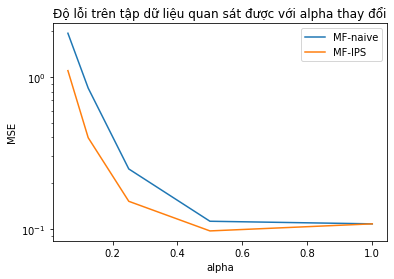

In [98]:
plt.plot(alphas,MSE_naive, label = "MF-naive")
plt.plot(alphas,MSE_IPS, label = "MF-IPS")
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Độ lỗi trên tập dữ liệu quan sát được với alpha thay đổi')

# ticks = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.7]
# plt.yticks(ticks)

plt.yscale('log')
plt.legend()
plt.show()